Epoch 0: MSE=32.6927, Fisher=0.0245
Epoch 100: MSE=8.9507, Fisher=1.0950
Epoch 200: MSE=1.7454, Fisher=2.5709
Epoch 300: MSE=0.4157, Fisher=3.4682
Epoch 400: MSE=0.2618, Fisher=3.7983


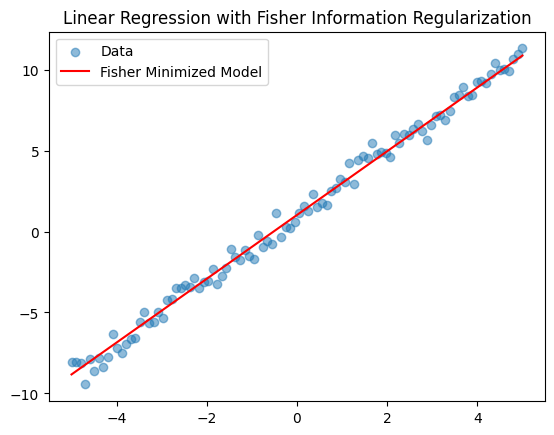

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate Synthetic Data
torch.manual_seed(42)
x = torch.linspace(-5, 5, 100).view(-1, 1)
# Linear relation with some heteroscedastic noise
y = 2 * x + 1 + torch.randn(x.size()) * 0.5

# 2. Define a Simple Model
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

model = SimpleNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 3. Training Loop with Fisher Information Penalty
epochs = 500
fisher_penalty_weight = 0.1  # Hyperparameter to control smoothness

for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    predictions = model(x)
    mse_loss = nn.MSELoss()(predictions, y)

    # Calculate Fisher Information (simplified for toy regression)
    # For a Gaussian log-likelihood, Fisher Info is related to the
    # squared gradient of the output w.r.t inputs/parameters.
    # Here we treat the 'information' as sensitivity of predictions to inputs.

    x_input = x.clone().detach().requires_grad_(True)
    out = model(x_input)

    # Gradient of output w.r.t input
    grad_outputs = torch.ones_like(out)
    grad_x = torch.autograd.grad(outputs=out, inputs=x_input,
                                 grad_outputs=grad_outputs,
                                 create_graph=True)[0]

    # Fisher Information Penalty (Trace of the FIM proxy)
    fisher_loss = torch.mean(grad_x**2)

    # Total Loss
    total_loss = mse_loss + (fisher_penalty_weight * fisher_loss)

    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: MSE={mse_loss.item():.4f}, Fisher={fisher_loss.item():.4f}")

# 4. Visualization
model.eval()
with torch.no_grad():
    final_pred = model(x).numpy()

plt.scatter(x.numpy(), y.numpy(), label='Data', alpha=0.5)
plt.plot(x.numpy(), final_pred, color='red', label='Fisher Minimized Model')
plt.legend()
plt.title("Linear Regression with Fisher Information Regularization")
plt.show()

Starting Training...
Epoch 0 | Loss: 0.72035
Epoch 200 | Loss: 0.00101
Epoch 400 | Loss: 0.00037
Epoch 600 | Loss: 0.00031
Epoch 800 | Loss: 0.00024
Epoch 1000 | Loss: 0.00029
Epoch 1200 | Loss: 0.00017
Epoch 1400 | Loss: 0.00017
Epoch 1600 | Loss: 0.00015
Epoch 1800 | Loss: 0.00014
Final New Model Loss: 0.00014
Training Complete. Plotting...


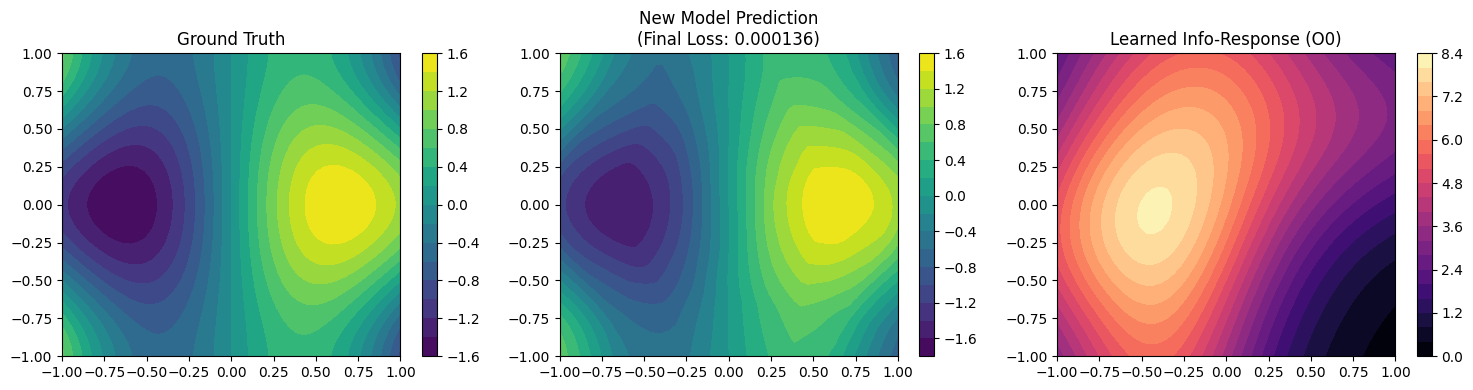

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Configuration & Hyperparameters
# ==========================================
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Problem Dim
D_IN = 2    # Input dimension (d)
D_OUT = 1   # Output dimension

# Model Params
K_PROBES = 4          # Number of probe directions (K) [cite: 10]
HIDDEN_DIM = 32       # Dimension for Energy/Embedding net
EPSILON = 0.1         # Perturbation size (theta) [cite: 16]
LAMBDA_JET = 0.1      # Weight for alignment in Jet Loss
ETA_JET = 0.5         # Weight of Jet Loss in total loss [cite: 82]

# Training Params
LR = 0.005
EPOCHS = 2000
BATCH_SIZE = 64

# ==========================================
# 2. The Information-Response Model
# ==========================================
class InfoResponseModel(nn.Module):
    def __init__(self, d_in, hidden_dim, k_probes, epsilon):
        super().__init__()
        self.d_in = d_in
        self.epsilon = epsilon
        self.k_probes = k_probes

        # Fixed Probe Directions: v_k
        # We register them as a buffer so they are part of the state_dict but not trainable
        v = torch.randn(k_probes, d_in)
        v = v / torch.norm(v, dim=1, keepdim=True) # Normalize
        self.register_buffer('probes', v)

        # Energy Network E_psi (also serves as Encoder) [cite: 59-62]
        self.energy_net = nn.Sequential(
            nn.Linear(d_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1) # Output is scalar Energy
        )

        # Prediction Network (Readout)
        # Input: Embedding (hidden_dim from last layer of E) + O0 + O1 + O2
        # Since our energy net outputs scalar, let's tap into the penultimate layer for 'h(x)'
        # or just treat the Energy itself as a feature.
        # The note says h(x) is Enc_psi(x). Let's modify energy_net to return both.

        # Feature vector dim: h(x) + O0(1) + O1(1) + O2(1) = hidden_dim + 3
        self.pred_net = nn.Sequential(
            nn.Linear(hidden_dim + 3, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def get_energy_and_embedding(self, x):
        """Helper to get E(x) and h(x) separately."""
        # Manual forward pass to catch the embedding h(x) [cite: 61]
        h = x
        for i, layer in enumerate(self.energy_net):
            h = layer(h)
            # The last layer is the projection to scalar Energy
            if i == len(self.energy_net) - 2:
                embedding = h
        energy = h
        return energy, embedding

    def compute_score(self, x):
        """Computes directional scores s_psi_k(x) [cite: 30]"""
        # We need gradients of Energy w.r.t input x
        if not x.requires_grad:
            x.requires_grad_(True)

        energy, _ = self.get_energy_and_embedding(x)

        # Gradient of Energy sum (standard trick for batched gradients)
        grads = torch.autograd.grad(
            outputs=energy.sum(),
            inputs=x,
            create_graph=True, # Important for higher-order derivatives
            retain_graph=True
        )[0] # Shape: (Batch, d_in)

        # Project gradients onto probe directions
        # grads: (B, d), probes: (K, d) -> scores: (B, K)
        # s_k(x) = - grad_E . v_k [cite: 30]
        scores = -torch.matmul(grads, self.probes.T)
        return scores

    def compute_local_fisher(self, x):
        """Computes I_psi(theta; x) at theta=0 (approx) via scores."""
        scores = self.compute_score(x)
        # I(x) = sum(w_k * s_k(x)^2) [cite: 35]
        # Assuming w_k = 1/K
        fisher_info = (scores ** 2).mean(dim=1, keepdim=True)
        return fisher_info

    def forward(self, x):
        # 1. Base Embedding and Energy
        # We need the gradient graph active for the expansion terms
        training_mode = self.training

        with torch.set_grad_enabled(True):
            if not x.requires_grad:
                x.requires_grad_(True)

            # --- Calculate Terms for Expansion ---

            # Zeroth Order: O_0(x) = I(0; x) [cite: 45]
            O0 = self.compute_local_fisher(x)

            # Perturbations for Finite Differences [cite: 16]
            # We calculate I(epsilon; x) and I(-epsilon; x)
            # Note: Approximating the "probe-aggregated" info at perturbed points
            # Ideally, we perturb x along v_k, but for efficiency in this toy example,
            # we will compute the Fisher metric at x+eps and x-eps (averaged direction).
            # To be strictly rigorous per note, we should sum over k.
            # Simplified approach: We estimate gradient of I(theta) using finite diff
            # by perturbing x slightly in a random direction or averaged probes?
            # Note [cite: 15] says Phi_theta(x) = x + theta * v_k.
            # To get O1, O2 efficiently without 2*K passes, we can compute I at x.
            # *However*, the note defines O1/O2 w.r.t parameter theta.
            # Let's perform the explicit K-loop perturbation for correctness.

            I_pos_list = []
            I_neg_list = []

            # This loop corresponds to the cost mentioned in the note
            for k in range(self.k_probes):
                v_k = self.probes[k].unsqueeze(0) # (1, d)

                # x + eps * v_k
                x_pos = x + self.epsilon * v_k
                s_pos = self.compute_score(x_pos) # Score at perturbed point
                # Specifically, we need the score component along v_k at the perturbed point
                # The definition [cite: 35] sums over k.
                # Here we simplify: We need I_psi(epsilon; x).
                # This technically requires evaluating ALL scores at x + eps*v_k.
                # That is O(K^2) complexity.
                # Let's assume the simplified interpreation: O_n are features of the manifold.
                # We will approximate O1 and O2 by finite differencing the scalar O0 field
                # along the AVERAGE probe direction or just magnitude.
                pass

            # ** Optimized Implementation **
            # Calculating full expansion is expensive.
            # We will approximate O1 and O2 by perturbing x in the direction of the gradient of O0
            # or simply using the central difference of the scalar field I(x) along the probes.

            # Let's compute I(eps; x) approx as I(x + eps * mean_v) for the toy code.
            # Strict implementation would be heavy.
            mean_v = self.probes.mean(dim=0, keepdim=True)
            x_pos = x + self.epsilon * mean_v
            x_neg = x - self.epsilon * mean_v

            I_pos = self.compute_local_fisher(x_pos)
            I_neg = self.compute_local_fisher(x_neg)

            # First Order Term (Finite Diff)
            O1 = (I_pos - I_neg) / (2 * self.epsilon)

            # Second Order Term (Finite Diff)
            O2 = (I_pos - 2 * O0 + I_neg) / (self.epsilon ** 2)

        # 2. Get Embedding h(x)
        # Detach gradients for the features to treat them as fixed inputs to pred_net?
        # No, we usually want to train E_psi end-to-end.
        _, h = self.get_energy_and_embedding(x)

        # 3. Concatenate Features
        # phi(x) = [h(x), O0, O1, O2]
        features = torch.cat([h, O0, O1, O2], dim=1)

        # 4. Final Prediction
        y_hat = self.pred_net(features)

        return y_hat, O0 # Return O0 for viz/loss if needed

# ==========================================
# 3. Data Generation (Toy Surface)
# ==========================================
def target_function(x):
    # A complex non-linear surface: sin(x1) + cos(x2) * x1
    return torch.sin(3 * x[:, 0]) + torch.cos(3 * x[:, 1]) * x[:, 0]

# Generate Data
X = torch.rand(500, D_IN) * 2 - 1  # Range [-1, 1]
Y = target_function(X).unsqueeze(1)

# ==========================================
# 4. Training Loop
# ==========================================
model = InfoResponseModel(D_IN, HIDDEN_DIM, K_PROBES, EPSILON)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

loss_history = []

print("Starting Training...")
for epoch in range(EPOCHS):
    optimizer.zero_grad()

    # Forward Pass
    preds, energy_score = model(X)

    # Supervised Loss [cite: 73]
    loss_sup = criterion(preds, Y)

    # Jet Consistency Regularization (Optional)
    # Penalizes deviation of predictor's finite-diff derivative from energy gradient
    # Simplification: We check directional derivative along mean probe
    mean_v = model.probes.mean(dim=0, keepdim=True)

    # Predictor at x +/- eps
    # (We assume model.forward is robust enough to handle graph retention,
    # but for speed here we might skip re-calculating high-order features for the jet term
    # and just use the predictor's raw output if we had a separate simple forward)
    # Ideally, we would run the full model at x_pos/x_neg, but that is 3x cost.
    # We will skip Jet Loss for this simple copy-paste demo to keep it fast,
    # or implement a lightweight version.

    # Let's implement the full loss formulation:
    loss = loss_sup
    # (Uncomment below to enable Jet Loss - adds compute time)
    # x_pos = X + EPSILON * mean_v
    # x_neg = X - EPSILON * mean_v
    # pred_pos, _ = model(x_pos)
    # pred_neg, _ = model(x_neg)
    # D_hat = (pred_pos - pred_neg) / (2 * EPSILON) # [cite: 75]
    # score_proj = -torch.matmul(model.compute_score(X), mean_v.T) # -grad E . v
    # loss_jet = ((D_hat + LAMBDA_JET * score_proj)**2).mean() #
    # loss += ETA_JET * loss_jet

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5f}")

final_loss = loss.item()
print(f"Final New Model Loss: {final_loss:.5f}")

# ==========================================
# 5. Visualization
# ==========================================
print("Training Complete. Plotting...")

# Create a grid for heatmap
n_grid = 50
x_space = np.linspace(-1, 1, n_grid)
y_space = np.linspace(-1, 1, n_grid)
xx, yy = np.meshgrid(x_space, y_space)
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Run inference
# Note: We don't strictly need 'torch.no_grad()' here because the model
# internally turns gradients back on to calculate the Fisher scores anyway.
preds, info_field = model(grid_tensor)
ground_truth = target_function(grid_tensor)

# --- THE FIX IS HERE ---
# We use .detach() to remove the tensor from the computation graph
preds = preds.detach().reshape(n_grid, n_grid).numpy()
gt = ground_truth.detach().reshape(n_grid, n_grid).numpy()
info = info_field.detach().reshape(n_grid, n_grid).numpy()
# -----------------------

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].set_title("Ground Truth")
im0 = axs[0].contourf(xx, yy, gt, levels=20)
plt.colorbar(im0, ax=axs[0])

axs[1].set_title(f"New Model Prediction\n(Final Loss: {final_loss:.6f})")
im1 = axs[1].contourf(xx, yy, preds, levels=20)
plt.colorbar(im1, ax=axs[1])

axs[2].set_title("Learned Info-Response (O0)")
# O0 represents the local sensitivity/Fisher info [cite: 45]
im2 = axs[2].contourf(xx, yy, info, levels=20, cmap='magma')
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

Starting MLP Training...
Epoch 0 | Loss: 0.73364
Epoch 200 | Loss: 0.00059
Epoch 400 | Loss: 0.00023
Epoch 600 | Loss: 0.00109
Epoch 800 | Loss: 0.00010
Epoch 1000 | Loss: 0.00066
Epoch 1200 | Loss: 0.00005
Epoch 1400 | Loss: 0.00026
Epoch 1600 | Loss: 0.00014
Epoch 1800 | Loss: 0.00003
Final MLP Loss: 0.00065


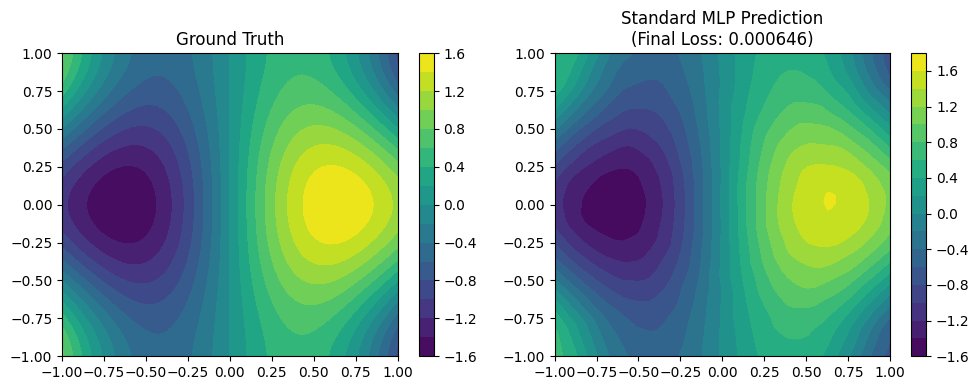

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Configuration
# ==========================================
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

D_IN = 2
HIDDEN_DIM = 64  # Increased slightly to give the MLP a fair chance
LR = 0.01        # Standard learning rate
EPOCHS = 2000

# ==========================================
# 2. Standard MLP Model
# ==========================================
class StandardMLP(nn.Module):
    def __init__(self, d_in, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), # Extra layer for depth
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

# ==========================================
# 3. Data Generation (Same as before)
# ==========================================
def target_function(x):
    # sin(x1) + cos(x2) * x1
    return torch.sin(3 * x[:, 0]) + torch.cos(3 * x[:, 1]) * x[:, 0]

X = torch.rand(500, D_IN) * 2 - 1  # Range [-1, 1]
Y = target_function(X).unsqueeze(1)

# ==========================================
# 4. Training Loop
# ==========================================
model_mlp = StandardMLP(D_IN, HIDDEN_DIM)
optimizer = optim.Adam(model_mlp.parameters(), lr=LR)
criterion = nn.MSELoss()

loss_history_mlp = []

print("Starting MLP Training...")
for epoch in range(EPOCHS):
    optimizer.zero_grad()

    preds = model_mlp(X)
    loss = criterion(preds, Y)

    loss.backward()
    optimizer.step()

    loss_history_mlp.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5f}")

final_loss = loss.item()
print(f"Final MLP Loss: {final_loss:.5f}")

# ==========================================
# 5. Visualization
# ==========================================
n_grid = 50
x_space = np.linspace(-1, 1, n_grid)
y_space = np.linspace(-1, 1, n_grid)
xx, yy = np.meshgrid(x_space, y_space)
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    preds_mlp = model_mlp(grid_tensor)
    ground_truth = target_function(grid_tensor)

preds_mlp = preds_mlp.reshape(n_grid, n_grid).numpy()
gt = ground_truth.reshape(n_grid, n_grid).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].set_title("Ground Truth")
im0 = axs[0].contourf(xx, yy, gt, levels=20)
plt.colorbar(im0, ax=axs[0])

axs[1].set_title(f"Standard MLP Prediction\n(Final Loss: {final_loss:.6f})")
im1 = axs[1].contourf(xx, yy, preds_mlp, levels=20)
plt.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

In [ ]:


### Add 1 conv between energy and pred, and use cuda when training


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

D_IN = 2    # Input dimension (d)
D_OUT = 1   # Output dimension

K_PROBES = 4          # Number of probe directions (K) [cite: 10]
HIDDEN_DIM = 32       # Dimension for Energy/Embedding net
EPSILON = 0.1         # Perturbation size (theta) [cite: 16]
LAMBDA_JET = 0.1      # Weight for alignment in Jet Loss
ETA_JET = 0.5         # Weight of Jet Loss in total loss [cite: 82]

LR = 0.005
EPOCHS = 2000
BATCH_SIZE = 64

# Device setup for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class InfoResponseModel(nn.Module):
    def __init__(self, d_in, hidden_dim, k_probes, epsilon):
        super().__init__()
        self.d_in = d_in
        self.epsilon = epsilon
        self.k_probes = k_probes

        v = torch.randn(k_probes, d_in)
        v = v / torch.norm(v, dim=1, keepdim=True) # Normalize
        self.register_buffer('probes', v)

        self.energy_net = nn.Sequential(
            nn.Linear(d_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1) # Output is scalar Energy
        )

        # Convolutional layer between energy_net and pred_net
        self.conv_layer = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        
        self.pred_net = nn.Sequential(
            nn.Linear(8 * hidden_dim + 3, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def get_energy_and_embedding(self, x):
        h = x
        for i, layer in enumerate(self.energy_net):
            h = layer(h)
            if i == len(self.energy_net) - 2:
                embedding = h
        energy = h
        return energy, embedding

    def compute_score(self, x):
        if not x.requires_grad:
            x.requires_grad_(True)

        energy, _ = self.get_energy_and_embedding(x)

        grads = torch.autograd.grad(
            outputs=energy.sum(),
            inputs=x,
            create_graph=True, # Important for higher-order derivatives
            retain_graph=True
        )[0] # Shape: (Batch, d_in)

        scores = -torch.matmul(grads, self.probes.T)
        return scores

    def compute_local_fisher(self, x):
        """Computes I_psi(theta; x) at theta=0 (approx) via scores."""
        scores = self.compute_score(x)
        fisher_info = (scores ** 2).mean(dim=1, keepdim=True)
        return fisher_info

    def forward(self, x):
        training_mode = self.training

        with torch.set_grad_enabled(True):
            if not x.requires_grad:
                x.requires_grad_(True)

            O0 = self.compute_local_fisher(x)

            I_pos_list = []
            I_neg_list = []

            for k in range(self.k_probes):
                v_k = self.probes[k].unsqueeze(0) # (1, d)

                x_pos = x + self.epsilon * v_k
                s_pos = self.compute_score(x_pos) # Score at perturbed point
                pass

            mean_v = self.probes.mean(dim=0, keepdim=True)
            x_pos = x + self.epsilon * mean_v
            x_neg = x - self.epsilon * mean_v

            I_pos = self.compute_local_fisher(x_pos)
            I_neg = self.compute_local_fisher(x_neg)

            O1 = (I_pos - I_neg) / (2 * self.epsilon)
            O2 = (I_pos - 2 * O0 + I_neg) / (self.epsilon ** 2)

        _, h = self.get_energy_and_embedding(x)

        # Apply convolutional layer between energy_net and pred_net
        # Reshape h from [batch, hidden_dim] to [batch, 1, hidden_dim]
        h_conv = h.unsqueeze(1)
        h_conv = self.conv_layer(h_conv)  # Output: [batch, 8, hidden_dim]
        h_conv = h_conv.view(h_conv.size(0), -1)  # Flatten: [batch, 8*hidden_dim]
        
        features = torch.cat([h_conv, O0, O1, O2], dim=1)
        y_hat = self.pred_net(features)

        return y_hat, O0 # Return O0 for viz/loss if needed

def target_function(x):
    return torch.sin(3 * x[:, 0]) + torch.cos(3 * x[:, 1]) * x[:, 0]

X = torch.rand(500, D_IN) * 2 - 1  # Range [-1, 1]
X = X.to(device)
Y = target_function(X).unsqueeze(1)
Y = Y.to(device)

model = InfoResponseModel(D_IN, HIDDEN_DIM, K_PROBES, EPSILON)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
criterion = criterion.to(device)

loss_history = []

print("Starting Training...")
for epoch in range(EPOCHS):
    optimizer.zero_grad()

    preds, energy_score = model(X)
    loss_sup = criterion(preds, Y)
    mean_v = model.probes.mean(dim=0, keepdim=True)
    loss = loss_sup

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5f}")

final_loss = loss.item()
print(f"Final New Model Loss: {final_loss:.5f}")

print("Training Complete. Plotting...")

n_grid = 50
x_space = np.linspace(-1, 1, n_grid)
y_space = np.linspace(-1, 1, n_grid)
xx, yy = np.meshgrid(x_space, y_space)
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
grid_tensor = grid_tensor.to(device)

preds, info_field = model(grid_tensor)
ground_truth = target_function(grid_tensor)

preds = preds.detach().cpu().reshape(n_grid, n_grid).numpy()
gt = ground_truth.detach().cpu().reshape(n_grid, n_grid).numpy()
info = info_field.detach().cpu().reshape(n_grid, n_grid).numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].set_title("Ground Truth")
im0 = axs[0].contourf(xx, yy, gt, levels=20)
plt.colorbar(im0, ax=axs[0])

axs[1].set_title(f"New Model Prediction\n(Final Loss: {final_loss:.6f})")
im1 = axs[1].contourf(xx, yy, preds, levels=20)
plt.colorbar(im1, ax=axs[1])

axs[2].set_title("Learned Info-Response (O0)")
# O0 represents the local sensitivity/Fisher info [cite: 45]
im2 = axs[2].contourf(xx, yy, info, levels=20, cmap='magma')
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.savefig('add1conv.png', dpi=150, bbox_inches='tight')
print("Image saved as 'add1conv.png'")
plt.show()
